# Political Bias Classification with Bi-Directional LSTM Model

##### Importing Libraries and Loading data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_colwidth', -1)

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [2]:
df1 = pd.read_csv('/Users/feihuyan/Downloads/news/articles1.csv')
df2 = pd.read_csv('/Users/feihuyan/Downloads/news/articles2.csv')
df3 = pd.read_csv('/Users/feihuyan/Downloads/news/articles3.csv')

In [3]:
df = pd.concat([df1, df2, df3])

In [4]:
set(df['publication'])

{'Atlantic',
 'Breitbart',
 'Business Insider',
 'Buzzfeed News',
 'CNN',
 'Fox News',
 'Guardian',
 'NPR',
 'National Review',
 'New York Post',
 'New York Times',
 'Reuters',
 'Talking Points Memo',
 'Vox',
 'Washington Post'}

In [8]:
bias = { 'Atlantic': 2,
         'Breitbart': 1,
         'Business Insider': 2,
         'Buzzfeed News': 2,
         'CNN': 0,
         'Fox News': 1,
         'Guardian': 2,
         'NPR': 2,
         'National Review': 2,
         'New York Post': 2,
         'New York Times': 0,
         'Reuters': 2,
         'Talking Points Memo': 2,
         'Vox': 2,
         'Washington Post': 2}
df['bias'] = df['publication'].map(bias)

In [6]:
bias = { 'Atlantic': 0,
         'Breitbart': 1,
         'Business Insider': 0,
         'Buzzfeed News': 0,
         'CNN': 0,
         'Fox News': 1,
         'Guardian': 0,
         'NPR': 0,
         'National Review': 1,
         'New York Post': 1,
         'New York Times': 0,
         'Reuters': 2,
         'Talking Points Memo': 0,
         'Vox': 0,
         'Washington Post': 0}
df['bias'] = df['publication'].map(bias)

In [9]:
left = df[df['bias'] == 0]
right = df[df['bias'] == 1]

### Passage to Sentence 

In [10]:
from nltk.tokenize import sent_tokenize

In [11]:
def passage_to_sentences(df, political_affiliation):
    l = []
    for row in tqdm(df):
        for sentence in sent_tokenize(row):
            l.append(sentence)
    result = pd.DataFrame({'text': l, 'target': political_affiliation})
    return result

In [12]:
left_sent = passage_to_sentences(left['content'], 0)

100%|██████████| 19291/19291 [00:29<00:00, 652.70it/s] 


In [13]:
right_sent = passage_to_sentences(right['content'], 1)

100%|██████████| 28135/28135 [00:23<00:00, 1221.40it/s]


In [14]:
left_sent.head(5)

,text,target
0,WASHINGTON — Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration: They might win.,0
1,"The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for and Americans, handing House Republicans a big victory on issues.",0
2,"But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement.",0
3,That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government.,0
4,"To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years.",0


In [15]:
right_sent.head(5)

,text,target
0,"On Tuesday’s broadcast of CNN’s “Situation Room,” CNN Senior Washington Correspondent Jeff Zeleny stated that Chelsea Manning’s transition from a man to a woman “certainly played into” President Obama’s decision to commute Manning’s sentence, and “Without that, it’s hard to imagine, I think, this president would have done that.",1
1,"” Zeleny said, “I think a question that this president the White House will have to answer here — will answer, and I think it’s an important one, if — how much was the personal story of Chelsea Manning involved in this, because the outcry from the left was so strong on this.",1
2,"And she’s having a difficult time in federal prison, no question.",1
3,"But, to me, that is a central question here.",1
4,"Without that, you have to wonder if the outcome would be the same.",1


In [16]:
train_df = pd.concat([left_sent, right_sent])
train_df = train_df.sample(frac=1)
train_df.head(5)

,text,target
256509,"Apparently, the ugly attacks Rubio launched against Trump either did not work or ran their course.",1
146733,And it’s tricky to do.,0
258377,And I think given what she’s had to do in her competition with Bernie Sanders just to get the Democratic Party nomination — some say she’s moved to the Left.,1
262259,"” But Intelligence Community Inspector General I. Charles McCollough, now under attack by Team Clinton, confirmed, “IC classification officials reviewed two additional emails and judged that they contained classified State Department information when originated.",1
211982,"[The security breach, in which hackers gained access to dozens of computers including the workstation for former FDIC Chairwoman Sheila Bair, has also been the target of a probe by a congressional committee.",1


### Setting Up Embedding Matrix

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [18]:
max_features = 30000
maxlen = 25

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['text']))
X = tokenizer.texts_to_sequences(list(train_df['text']))
X = pad_sequences(X, maxlen = maxlen)
y = train_df['target']

In [19]:
embedding_size = 200
embedding_file = '/Users/feihuyan/Downloads/glove.twitter.27B.200d.txt'
embedding_index = {}
file = open(embedding_file)
for line in tqdm(file):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs

1193514it [00:52, 22904.03it/s]


In [20]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
print(X.shape)
print(y.shape)

(1498398, 25)
(1498398,)


In [22]:
embedding_matrix.shape

(30000, 200)

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SimpleRNN
from keras.optimizers import adam

## Stacking Bi-Directional LSTM with Embeddings

#### Using Max Pooling

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size, weights=[embedding_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,
                                                      recurrent_dropout=0.5,
                                                      return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                                      recurrent_dropout=0.5,
                                                      return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                      recurrent_dropout=0.5,
                                                      return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         6000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 40)                5160      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0

In [25]:
batch_size = 100
epochs = 5
history = model.fit(X, 
                     y, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_split=0.2)

Epoch 1/5
11988/11988 [==============================] - 5517s 460ms/step - loss: 0.5177 - accuracy: 0.7402 - val_loss: 0.4697 - val_accuracy: 0.7645
Epoch 2/5
11988/11988 [==============================] - 5474s 457ms/step - loss: 0.4628 - accuracy: 0.7777 - val_loss: 0.4548 - val_accuracy: 0.7752
Epoch 3/5
11988/11988 [==============================] - 5616s 468ms/step - loss: 0.4365 - accuracy: 0.7937 - val_loss: 0.4594 - val_accuracy: 0.7706
Epoch 4/5
11988/11988 [==============================] - 5555s 463ms/step - loss: 0.4115 - accuracy: 0.8088 - val_loss: 0.4516 - val_accuracy: 0.7807
Epoch 5/5
11988/11988 [==============================] - 5907s 493ms/step - loss: 0.3852 - accuracy: 0.8230 - val_loss: 0.4756 - val_accuracy: 0.7762


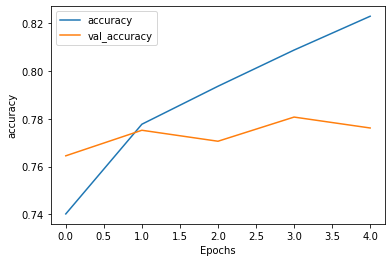

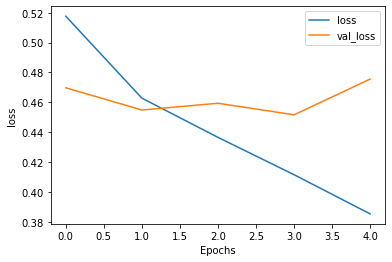

In [26]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [79]:
model.save('news_stack_lstm.h5')

In [27]:
def test(text, true_class, passage=True, check=True):
    '''
    Takes sentence or passage as input, 
    returns ideological bias estimate in text'''
    test_text = []
    if passage: 
        for sentence in sent_tokenize(text):
            test_text.append(sentence)
    else:
        test_text = [text]
        
    text_token = tokenizer.texts_to_sequences(test_text)
    text_pad = pad_sequences(text_token, maxlen = maxlen)
    pred_class = model.predict_classes(text_pad)
    pred_score = model.predict(text_pad)
    naive_loss = abs(true_class - pred_score)
    
    pol_class = 'right'
    content = 'sentence'
    success = 'succeeds'
 
    pred_score_passage = np.sum(pred_score)/int(len(text_pad))
    if passage:
        pred_class = 1
        if pred_score_passage < 0.5: pred_class, pol_class = 0, 'left'
        bias = float(abs(0.5-pred_score_passage)/0.5*100)
        content = 'passage'
        if check: 
            if pred_class != true_class: success = 'fails'
    else:
        if pred_score < 0.5: pol_class = 'left'
        bias = float(abs(0.5-pred_score)/0.5*100)
        if check: 
            if pred_class != true_class: success = 'fails'
    
    print('===========================================================================')
    print('Your answer:')
    print('------------')
    print(f'  - This {content} leans toward the {pol_class} in the political spectrum.')
    print(f'  - It is approximately {bias: .2f}% percent biased to the {pol_class}.')
    print(f'  - This model {success} in predicting the political bias.')
    print('===========================================================================')
    
    return pred_class, pred_score, naive_loss

### Test Case A: right-leaning sentences

##### A1).

In [28]:
fox_test1 = 'Top Republicans hit back at Pelosi for hypercharged language, calling GOP enemies of the state'

In [29]:
fox_test1

'Top Republicans hit back at Pelosi for hypercharged language, calling GOP enemies of the state'

In [30]:
test(fox_test1, 1, passage=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  49.07% percent biased to the right.
  - This model succeeds in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.7453557]], dtype=float32),
 array([[0.25464427]], dtype=float32))

##### A2).

In [31]:
fox_test2 = 'While the 2016 Republican convention was riddled with tension and protests over Donald Trump"s rise at the GOP nominee, four years later the gathering is dissent free as the four-day confab serves as a celebration of Trump – and a testament to the president"s complete takeover of the party.'

In [32]:
fox_test2

'While the 2016 Republican convention was riddled with tension and protests over Donald Trump"s rise at the GOP nominee, four years later the gathering is dissent free as the four-day confab serves as a celebration of Trump – and a testament to the president"s complete takeover of the party.'

In [33]:
test(fox_test2, 1, passage=False)

Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  90.21% percent biased to the right.
  - This model succeeds in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.9510536]], dtype=float32),
 array([[0.04894638]], dtype=float32))

### Test Case B: left-leaning sentences

##### B1).

In [34]:
cnn_test = 'House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018.'

In [35]:
cnn_test

'House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018.'

In [36]:
test(cnn_test, 0, passage=False)

Your answer:
------------
  - This sentence leans toward the left in the political spectrum.
  - It is approximately  39.03% percent biased to the left.
  - This model succeeds in predicting the political bias.


(array([[0]], dtype=int32),
 array([[0.3048725]], dtype=float32),
 array([[0.3048725]], dtype=float32))

##### B2).

In [37]:
cnn_test2 = 'Evidence is growing that in November, the GOP could be pushed back further into its strongholds and lose more ground in diverse, growing metropolitan America, even if Trump finds a way to overcome his persistent deficits in national polls to Democratic nominee Joe Biden.'

In [38]:
cnn_test2

'Evidence is growing that in November, the GOP could be pushed back further into its strongholds and lose more ground in diverse, growing metropolitan America, even if Trump finds a way to overcome his persistent deficits in national polls to Democratic nominee Joe Biden.'

In [39]:
test(cnn_test2, 0, passage=False)

Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  36.25% percent biased to the right.
  - This model fails in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.68125]], dtype=float32),
 array([[0.68125]], dtype=float32))

### Test Case C: right-leaning passages

##### C1).

In [40]:
fox_test_passage = 'The Journal article, which cites the International Monetary Fund, states that the pandemic and the resulting economic shutdowns have led to the expectation that global output will fall 5% this year, which is “far worse than during the [2008] financial crisis. It has also led to 400 million jobs lost worldwide, according to the International Labor Organization, with 13 million job losses in the U.S. alone.'

In [41]:
fox_test_passage

'The Journal article, which cites the International Monetary Fund, states that the pandemic and the resulting economic shutdowns have led to the expectation that global output will fall 5% this year, which is “far worse than during the [2008] financial crisis. It has also led to 400 million jobs lost worldwide, according to the International Labor Organization, with 13 million job losses in the U.S. alone.'

In [42]:
test(fox_test_passage, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  75.76% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.9533558],
        [0.8042194]], dtype=float32),
 array([[0.04664421],
        [0.19578058]], dtype=float32))

##### C2).

In [43]:
fox_test_passage2 = 'On Tuesday, Israeli Defense Minister Benny Gantz had his first official talk with his UAE counterpart. The two discussed security cooperation between their countries and other regional issues. This, after Pompeo met Monday with Israeli Prime Minister Benjamin Netanyahu in Jerusalem and in a statement afterward slammed others for not supporting more pressure on Iranian leadership in Tehran. But to the backdrop of the election year, America’s top diplomat has been pressing hard to mend regional ties for Israel while isolating Iran. He was at the United Nations last week where he triggered a sanctions snapback on Iran for violations of the 2015 nuclear deal and continued provocative action in the Middle East.'

In [44]:
fox_test_passage2

'On Tuesday, Israeli Defense Minister Benny Gantz had his first official talk with his UAE counterpart. The two discussed security cooperation between their countries and other regional issues. This, after Pompeo met Monday with Israeli Prime Minister Benjamin Netanyahu in Jerusalem and in a statement afterward slammed others for not supporting more pressure on Iranian leadership in Tehran. But to the backdrop of the election year, America’s top diplomat has been pressing hard to mend regional ties for Israel while isolating Iran. He was at the United Nations last week where he triggered a sanctions snapback on Iran for violations of the 2015 nuclear deal and continued provocative action in the Middle East.'

In [45]:
test(fox_test_passage2, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  23.49% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.8274263 ],
        [0.6114445 ],
        [0.57166356],
        [0.48463285],
        [0.5921058 ]], dtype=float32),
 array([[0.17257369],
        [0.38855553],
        [0.42833644],
        [0.51536715],
        [0.4078942 ]], dtype=float32))

### Test Case D: left-leaning passages

##### D1).

In [46]:
cnn_test_passage = 'Compared with the 2016 GOP convention, which rippled with unresolved tension and resistance to Trump rise, the conspicuous absence of dissent at this years event underscores how the President has stamped the party with his trademark as surely as if it were one of his downtown skyscrapers. The party choice to skip passing a platform and instead approve a brief statement declaring it will enthusiastically support the Presidents America-first agenda testifies to his triumph.'           

In [47]:
cnn_test_passage

'Compared with the 2016 GOP convention, which rippled with unresolved tension and resistance to Trump rise, the conspicuous absence of dissent at this years event underscores how the President has stamped the party with his trademark as surely as if it were one of his downtown skyscrapers. The party choice to skip passing a platform and instead approve a brief statement declaring it will enthusiastically support the Presidents America-first agenda testifies to his triumph.'

In [48]:
test(cnn_test_passage, 0, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  20.82% percent biased to the left.
  - This model succeeds in predicting the political bias.


(0,
 array([[0.04622942],
        [0.74560666]], dtype=float32),
 array([[0.04622942],
        [0.74560666]], dtype=float32))

##### D2).

In [49]:
cnn_test_passage2 = 'In 2016, Trump won very few of the states with the most immigrants, the most college graduates or the fewest White Christians, and polls show he could lose several of the small number he did carry in each category. House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018. That same demographic and geographic realignment threatens embattled GOP senators in Arizona, Colorado, North Carolina, Maine and potentially Iowa, Georgia and conceivably even Texas. The conundrum facing the GOP will be visible in the passionate support for the President on display this week. As the previously Republican-leaning voters who can"t abide Trump"s definition drift away from the party a dynamic that Democrats highlighted last week by featuring so many prominent Republicans at their own convention -- what"s left are those most bonded to Trump"s polarizing approach. That will make it difficult to build a coalition for changing direction if Trump loses this fall, even if he takes down the GOP Senate majority with him.'

In [50]:
cnn_test_passage2

'In 2016, Trump won very few of the states with the most immigrants, the most college graduates or the fewest White Christians, and polls show he could lose several of the small number he did carry in each category. House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018. That same demographic and geographic realignment threatens embattled GOP senators in Arizona, Colorado, North Carolina, Maine and potentially Iowa, Georgia and conceivably even Texas. The conundrum facing the GOP will be visible in the passionate support for the President on display this week. As the previously Republican-leaning voters who can"t abide Trump"s definition drift away from the party a dynamic that Democrats highlighted last week by featuring so many prominent Republicans at their own convention -- what"s left are those most bonded to Trump"s polarizing approach. That will make it difficult to

In [51]:
test(cnn_test_passage2, 0, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  0.75% percent biased to the right.
  - This model fails in predicting the political bias.


(1,
 array([[0.58913153],
        [0.3048725 ],
        [0.78584087],
        [0.28354204],
        [0.50860655],
        [0.55037624]], dtype=float32),
 array([[0.58913153],
        [0.3048725 ],
        [0.78584087],
        [0.28354204],
        [0.50860655],
        [0.55037624]], dtype=float32))

### More Testing

In [53]:
breitbart1 = 'He also says Trump is no hawk, wisely wielding the sword when required and believing in seeking peace instead of perpetual conflict. He then praises Trump"s peace deal between Israel and the United Arab Emirates. He says this week, Afghan officials will start peace negotiations with the Taliban to end America"s longest war.'

In [54]:
breitbart1

'He also says Trump is no hawk, wisely wielding the sword when required and believing in seeking peace instead of perpetual conflict. He then praises Trump"s peace deal between Israel and the United Arab Emirates. He says this week, Afghan officials will start peace negotiations with the Taliban to end America"s longest war.'

In [55]:
test(breitbart1, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  51.97% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.59943   ],
        [0.85565877],
        [0.82439196]], dtype=float32),
 array([[0.40056998],
        [0.14434123],
        [0.17560804]], dtype=float32))

In [56]:
crenshaw = 'America is a fabric woven from the threads of history’s best stories, best attributes, and greatest ideas. The American spirit reflects the oldest and most important virtues: self-sacrifice, courage, tolerance, love of country, grace, and passion for human achievement, We can decide right now that American greatness will not be rejected nor squandered. As the American founding was grounded in individual liberty, so will be our future.'

In [57]:
crenshaw

'America is a fabric woven from the threads of history’s best stories, best attributes, and greatest ideas. The American spirit reflects the oldest and most important virtues: self-sacrifice, courage, tolerance, love of country, grace, and passion for human achievement, We can decide right now that American greatness will not be rejected nor squandered. As the American founding was grounded in individual liberty, so will be our future.'

In [58]:
test(crenshaw, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  35.55% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.41671482],
        [0.8430486 ],
        [0.77341557]], dtype=float32),
 array([[0.5832852 ],
        [0.15695143],
        [0.22658443]], dtype=float32))

In [59]:
blackburn = 'Leftists try to turn them into villains. They try to "cancel" them. But I"m here to tell you that these heroes can"t be cancelled. Tennessee is full of them—after all, we’re the volunteer state.'

In [60]:
blackburn

'Leftists try to turn them into villains. They try to "cancel" them. But I"m here to tell you that these heroes can"t be cancelled. Tennessee is full of them—after all, we’re the volunteer state.'

In [61]:
test(blackburn, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  60.23% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.9580717 ],
        [0.6917716 ],
        [0.9294432 ],
        [0.62528735]], dtype=float32),
 array([[0.04192829],
        [0.30822837],
        [0.07055682],
        [0.37471265]], dtype=float32))

In [65]:
commondream = 'As President Donald Trump and top members of his administration continue their push to deliver another round of tax cuts to rich investors, an analysis published Tuesday by the Institute for Policy Studies and Americans for Tax Fairness showed that U.S. billionaires have seen their collective wealth soar by nearly $800 billion since Covid-19 began spreading rapidly across the country in March.'

In [66]:
commondream

'As President Donald Trump and top members of his administration continue their push to deliver another round of tax cuts to rich investors, an analysis published Tuesday by the Institute for Policy Studies and Americans for Tax Fairness showed that U.S. billionaires have seen their collective wealth soar by nearly $800 billion since Covid-19 began spreading rapidly across the country in March.'

In [68]:
test(commondream, 0, passage=False)

Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  68.44% percent biased to the right.
  - This model fails in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.84219825]], dtype=float32),
 array([[0.84219825]], dtype=float32))

In [69]:
cnn2 = 'It"s a historic moment in the sporting world that will stand starkly against the Republican messages of support for police and regular calls for athletes to stick to sports instead of making political statements. Pence is expected to address players kneeling during the National Anthem as a form of protest against police brutality and both Trump and Pence have repeatedly criticized players who have taken a knee as disrespectful to the flag and to American values.'

In [70]:
cnn2

'It"s a historic moment in the sporting world that will stand starkly against the Republican messages of support for police and regular calls for athletes to stick to sports instead of making political statements. Pence is expected to address players kneeling during the National Anthem as a form of protest against police brutality and both Trump and Pence have repeatedly criticized players who have taken a knee as disrespectful to the flag and to American values.'

In [71]:
test(cnn2, 0, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  51.31% percent biased to the left.
  - This model succeeds in predicting the political bias.


(0,
 array([[0.14254025],
        [0.34436998]], dtype=float32),
 array([[0.14254025],
        [0.34436998]], dtype=float32))

In [72]:
cnn_pas1 = 'If the first night of the Republican National Convention was about letting the Trump team”s unhinged flag fly, night two was an attempt to leverage Trumpworld women to send a message of sanity and compassion. The scary thing is, it might have worked. First Lady Melania Trump closed out the night with a long speech that was notable for its demonstration of basic human compassion and decency -- recognizing that there is still a pandemic going on and that it continues to kill Americans, while other speakers simply referred to Covid-19 in the past tense. "At least claimed to care about the suffering of others" is a startlingly low bar, and yet Melania Trump was one of the few convention speakers who managed to clear it. The rest of the turn toward the soft and the gentle largely came from other women in Trump”s orbit. A brief vignette about the women of the Trump administration highlighted the mothers who have served as press secretary (three in four years, plus Sean Spicer), as well as Ronna McDaniel, the self-described "housewife" who runs the Republican National Committee. The women”s empowerment, independence and maternal status were all front and center. And their message was clear: Trump cares about women. Or, at the very least, you can now vote for Trump and have some defense when people call you sexist. In the Trump administration”s telling, his presidency has been excellent for women: It has "empowered" us, made us more money and put us in high-level positions. But these claims are far from the truth. The First Lady, who years ago parroted the racist claim that Barack Obama might not be a US citizen, used her convention dais to repeat her husband”s flat-out lie that he had appointed a historic number of women to positions of power -- a line that the administration has been pushing for years, when in fact Trump has appointed fewer women than any president in recent history. The convention put a feminist veneer over a party that has long been hostile to the rights of women, and a President who stands accused of sexual harassment (which he denies), has bragged about grabbing women”s genitals, calls women he dislikes all manner of derogatory names and has boasted about refusing to so much as change a diaper because raising children is women”s work. Even the RNC”s own segments about women were telling, as women were often presented as mothers first -- all three of Trump”s female press secretaries were defined by their parental status, and Melania Trump referred to "mothers and parents" instead of "mothers and fathers." This stereotype that the convention played on -- that motherhood is a woman"s highest calling -- is the same one that helps to keep women out of power and, too often, professionally and personally reliant on mediocre men like Trump. As the carefully produced show put up imagery of suffragists marching for the vote, a right that was secured for women 100 years ago, a savvy viewer would hopefully realize that today”s Republican Party -- a conservative, anti-feminist party -- is the heir to those who fought against them. The GOP even gave us proof in the form of Abby Johnson, a speaker at the RNC who is an anti-abortion advocate --- and who tweeted in May her belief that if a married woman disagrees with her husband on who to vote for, she should defer to his political choice. It was quite a show. The Republican Party seems to understand that liberal ideas -- racial justice, women”s rights, health care access, diversity, welcoming immigrants -- are actually pretty popular in the United States. But in practice they are also often antagonistic to these same ideals; GOP leaders functionally undercut them at every turn. They and their voters understand that these are good values to have, and so they want to give the appearance of embracing them without actually having to live them. In the same way, the President who leads chants of "build the wall" used the White House to conduct a televised naturalization ceremony -- offensive enough in its egregious use of The People House for partisan campaign purposes, but telling in that this administration wants credit for doing the right thing for immigrants while actually causing them considerable harm.'

In [73]:
cnn_pas1

'If the first night of the Republican National Convention was about letting the Trump team”s unhinged flag fly, night two was an attempt to leverage Trumpworld women to send a message of sanity and compassion. The scary thing is, it might have worked. First Lady Melania Trump closed out the night with a long speech that was notable for its demonstration of basic human compassion and decency -- recognizing that there is still a pandemic going on and that it continues to kill Americans, while other speakers simply referred to Covid-19 in the past tense. "At least claimed to care about the suffering of others" is a startlingly low bar, and yet Melania Trump was one of the few convention speakers who managed to clear it. The rest of the turn toward the soft and the gentle largely came from other women in Trump”s orbit. A brief vignette about the women of the Trump administration highlighted the mothers who have served as press secretary (three in four years, plus Sean Spicer), as well as R

In [74]:
test(cnn_pas1, 0, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  10.57% percent biased to the left.
  - This model succeeds in predicting the political bias.


(0,
 array([[0.02871594],
        [0.50526404],
        [0.85289866],
        [0.38981223],
        [0.11670643],
        [0.321648  ],
        [0.15072021],
        [0.5290451 ],
        [0.85348845],
        [0.8251424 ],
        [0.68836206],
        [0.46878803],
        [0.4189396 ],
        [0.20954624],
        [0.5844393 ],
        [0.5745114 ],
        [0.37248567],
        [0.29533672],
        [0.1831983 ],
        [0.1402424 ],
        [0.6620529 ],
        [0.6661685 ]], dtype=float32),
 array([[0.02871594],
        [0.50526404],
        [0.85289866],
        [0.38981223],
        [0.11670643],
        [0.321648  ],
        [0.15072021],
        [0.5290451 ],
        [0.85348845],
        [0.8251424 ],
        [0.68836206],
        [0.46878803],
        [0.4189396 ],
        [0.20954624],
        [0.5844393 ],
        [0.5745114 ],
        [0.37248567],
        [0.29533672],
        [0.1831983 ],
        [0.1402424 ],
        [0.6620529 ],
        [0.6661685 ]], dtype=floa

In [75]:
breitbart2 = 'Night three opens with a prayer from Rabbi Aryeh Spero, president of the Conference of Jewish Affairs. After the pledge of allegiance, South Dakota Gov. Kristi Noem say she is here tonight because America is an exceptional nation founded on equality, freedom, and opportunity. She says our founding principles are under attack and this election is between a man who believes in these ideals and someone who doesn’t and hasn’t built anything. After citing James Madison extensively, she says Americans will not be a subclass of experts. Noem rips the violence of the mobs and says the people who can’t afford to flee are left to fend for themselves.'

In [76]:
breitbart2

'Night three opens with a prayer from Rabbi Aryeh Spero, president of the Conference of Jewish Affairs. After the pledge of allegiance, South Dakota Gov. Kristi Noem say she is here tonight because America is an exceptional nation founded on equality, freedom, and opportunity. She says our founding principles are under attack and this election is between a man who believes in these ideals and someone who doesn’t and hasn’t built anything. After citing James Madison extensively, she says Americans will not be a subclass of experts. Noem rips the violence of the mobs and says the people who can’t afford to flee are left to fend for themselves.'

In [77]:
test(breitbart2, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  41.78% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.5896231 ],
        [0.5668864 ],
        [0.93163466],
        [0.8703337 ],
        [0.669606  ],
        [0.6253987 ]], dtype=float32),
 array([[0.4103769 ],
        [0.43311357],
        [0.06836534],
        [0.12966633],
        [0.33039403],
        [0.3746013 ]], dtype=float32))

In [80]:
breitbart3 = 'I want my daughter to grow up in President Donald Trump’s America, she said. She spoke about her values, the importance of God in the public square, respect for life, and safe neighborhoods, and she said that President Trump would continue fighting for them. “I choose to work for this President for her,” she said. “When I look into my baby’s eyes, I see a new life, a miracle for which I have a solemn responsibility to protect.” McEnany also spoke about choosing to have a preventative mastectomy, recalling that she was “blown away” that President Donald Trump called her personally to check in on her after the surgery. “I can tell you that this President loves the American people, stands by Americans with preexisting conditions, and supports working moms,” she said. Since becoming press secretary, McEnany said she witnessed, personally, the president’s love for the American people, calling parents who lost children to crime, writing to loved ones of fallen soldiers, fighting for Americans who lost their jobs. “The same way President Trump has supported me, he supports you,” she said. I see it every day.'

In [81]:
breitbart3

'I want my daughter to grow up in President Donald Trump’s America, she said. She spoke about her values, the importance of God in the public square, respect for life, and safe neighborhoods, and she said that President Trump would continue fighting for them. “I choose to work for this President for her,” she said. “When I look into my baby’s eyes, I see a new life, a miracle for which I have a solemn responsibility to protect.” McEnany also spoke about choosing to have a preventative mastectomy, recalling that she was “blown away” that President Donald Trump called her personally to check in on her after the surgery. “I can tell you that this President loves the American people, stands by Americans with preexisting conditions, and supports working moms,” she said. Since becoming press secretary, McEnany said she witnessed, personally, the president’s love for the American people, calling parents who lost children to crime, writing to loved ones of fallen soldiers, fighting for America

In [82]:
test(breitbart3, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  13.83% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.6152513 ],
        [0.7805917 ],
        [0.4215792 ],
        [0.57953906],
        [0.40641442],
        [0.85909486],
        [0.5053282 ],
        [0.3852301 ]], dtype=float32),
 array([[0.3847487 ],
        [0.21940827],
        [0.57842076],
        [0.42046094],
        [0.5935856 ],
        [0.14090514],
        [0.49467182],
        [0.61476994]], dtype=float32))